# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images/RetailAnalyticsTest")

C:\Users\xiaoy\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xiaoy\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xiaoy\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xiaoy\Anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py:522: FutureWarning: Passi

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:
import coco.coco as coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    DETECTION_MAX_INSTANCES = 200

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

C:\Users\xiaoy\Anaconda3\Lib\site-packages\pycocotools\coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\xiaoy\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\xiaoy\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\xiaoy\Anaconda3\Lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\xiaoy\Anaconda3\Lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\xiaoy\Anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\xiaoy\An

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


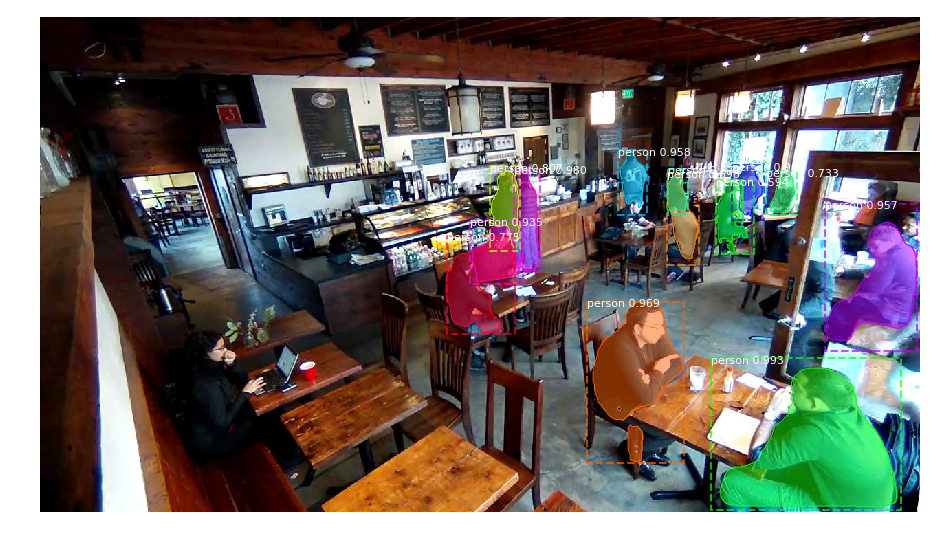

In [11]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread(os.path.join(IMAGE_DIR, "frame0019.jpg"))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [23]:
detections = results[0]
print(detections['masks'].shape)
for i in range(len(detections['class_ids'])):
    roi = detections["rois"][i]
    class_id = detections['class_ids'][i]
    mask = detections['masks'][:, :, i]
    print(roi, class_id, mask.shape)

(720, 1280, 41)
[ 474  967  716 1203] 1 (720, 1280)
[443 199 647 363] 1 (720, 1280)
[300 852 404 921] 57 (720, 1280)
[586 292 719 453] 1 (720, 1280)
[394 492 536 539] 57 (720, 1280)
[400 548 604 629] 57 (720, 1280)
[297 628 403 716] 1 (720, 1280)
[228 668 374 723] 1 (720, 1280)
[ 260  976  360 1034] 57 (720, 1280)
[294 913 393 970] 57 (720, 1280)
[ 307 1143  585 1279] 1 (720, 1280)
[481 624 711 732] 57 (720, 1280)
[456 780 680 921] 57 (720, 1280)
[396 549 447 600] 57 (720, 1280)
[ 501  864  655 1101] 61 (720, 1280)
[ 234 1037  351 1115] 1 (720, 1280)
[228 625 324 672] 1 (720, 1280)
[ 236  981  347 1036] 1 (720, 1280)
[415 787 649 923] 1 (720, 1280)
[322 764 389 831] 1 (720, 1280)
[213 648 261 679] 1 (720, 1280)
[424 258 490 369] 59 (720, 1280)
[271 959 352 986] 57 (720, 1280)
[328 586 455 675] 1 (720, 1280)
[508 940 542 965] 42 (720, 1280)
[232 914 288 943] 1 (720, 1280)
[262 841 305 885] 1 (720, 1280)
[392 169 448 227] 57 (720, 1280)
[393 585 466 659] 57 (720, 1280)
[272 321 307 365] 

In [35]:
peopleDetect = {}
detectClasses = detections['class_ids']
peopleDetect["rois"] = detections["rois"][detectClasses == 1]
peopleDetect["masks"] = detections["masks"][:, :, detectClasses == 1]
peopleDetect["scores"] = detections["scores"][detectClasses == 1]

In [37]:
for i in range(len(peopleDetect['rois'])):
    roi = peopleDetect["rois"][i]
    left = roi[0]
    right = roi[1]
    top = roi[2]
    bottom = roi[3]
    mask = peopleDetect['masks'][top:bottom, left:right, i]
    score = peopleDetect['scores'][i]
    print(roi, mask.shape, score)

[ 474  967  716 1203] (4, 493) 0.9976719
[443 199 647 363] (0, 0) 0.99278545
[586 292 719 453] (0, 0) 0.98792446
[297 628 403 716] (313, 331) 0.9705606
[228 668 374 723] (346, 440) 0.96834475
[ 307 1143  585 1279] (135, 836) 0.95136
[ 234 1037  351 1115] (369, 803) 0.91626054
[228 625 324 672] (348, 397) 0.90326387
[ 236  981  347 1036] (373, 745) 0.8981852
[415 787 649 923] (71, 372) 0.88487667
[322 764 389 831] (331, 442) 0.8555435
[213 648 261 679] (418, 435) 0.7740031
[328 586 455 675] (220, 258) 0.6651698
[232 914 288 943] (432, 682) 0.64169335
[262 841 305 885] (415, 579) 0.6286085
[ 291 1072  507 1182] (213, 781) 0.5637566
[343 657 514 751] (206, 314) 0.48179665
